In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

## Datasets

In [9]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
paths = [
            root_path / "2021-10-26-10-49-06_e2e_rec_ss20_elva",
            root_path / "2021-10-26-11-08-59_e2e_rec_ss20_elva_back",
            root_path / "2021-10-11-14-50-59_e2e_rec_vahi",
            root_path / "2021-10-14-13-08-51_e2e_rec_vahi_backwards"
]


dataset = NvidiaDataset(paths, camera="front_wide", transform=None)
positions_df = dataset.frames#[:15400]

/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 33045
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 33281
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-11-14-50-59_e2e_rec_vahi: 21211
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-14-13-08-51_e2e_rec_vahi_backwards: 13442


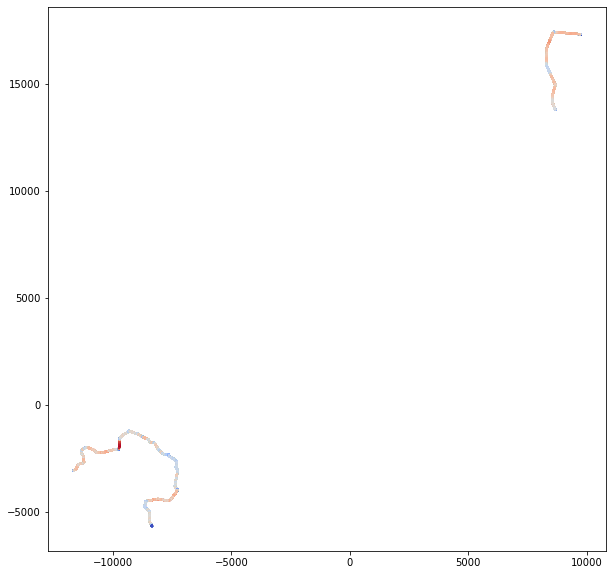

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(positions_df["position_x"], positions_df["position_y"],
            s=1,
            c=positions_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [11]:
velocity = 30
positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))
positions_df = positions_df[["position_x", "position_y", "position_x2", "position_y2", "yaw", "vehicle_speed", "image_path", "autonomous"]]

In [12]:
positions_df = positions_df[positions_df['position_x'].notna()]
positions_df

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed,image_path,autonomous
0,-8354.300258,-5678.252961,-8366.040594,-5650.645634,1.972889,0.000000,/media/romet/data2/datasets/rally-estonia/data...,False
1,-8354.300268,-5678.252958,-8366.040394,-5650.645542,1.972881,0.000000,/media/romet/data2/datasets/rally-estonia/data...,False
2,-8354.300285,-5678.252947,-8366.039929,-5650.645326,1.972863,0.000000,/media/romet/data2/datasets/rally-estonia/data...,False
3,-8354.300224,-5678.252932,-8366.039873,-5650.645313,1.972864,0.000000,/media/romet/data2/datasets/rally-estonia/data...,False
4,-8354.300146,-5678.252917,-8366.039663,-5650.645241,1.972859,0.000000,/media/romet/data2/datasets/rally-estonia/data...,False
...,...,...,...,...,...,...,...,...
13437,8653.050592,13849.532213,8663.094166,13821.263386,-1.229418,8.988350,/media/romet/data2/datasets/rally-estonia/data...,False
13438,8653.155896,13849.236891,8663.205386,13820.970165,-1.229209,8.990000,/media/romet/data2/datasets/rally-estonia/data...,False
13439,8653.257687,13848.951743,8663.315961,13820.688142,-1.228898,8.935287,/media/romet/data2/datasets/rally-estonia/data...,False
13440,8653.358300,13848.669388,8663.425468,13820.408954,-1.228584,8.957848,/media/romet/data2/datasets/rally-estonia/data...,False


In [15]:
positions_df.to_parquet('velocity_model/positions.parquet', compression='GZIP')

In [16]:
from velocity_model.velocity_model import VelocityModel

velocity_model = VelocityModel(positions_parquet='velocity_model/positions.parquet')

In [17]:
speed, distance = velocity_model.find_speed_for_position(8454., 15490., 1.95)
speed

8.009431966532162

/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 33045
Error mean: 0.03979453113683521, max: 2.632940203430808


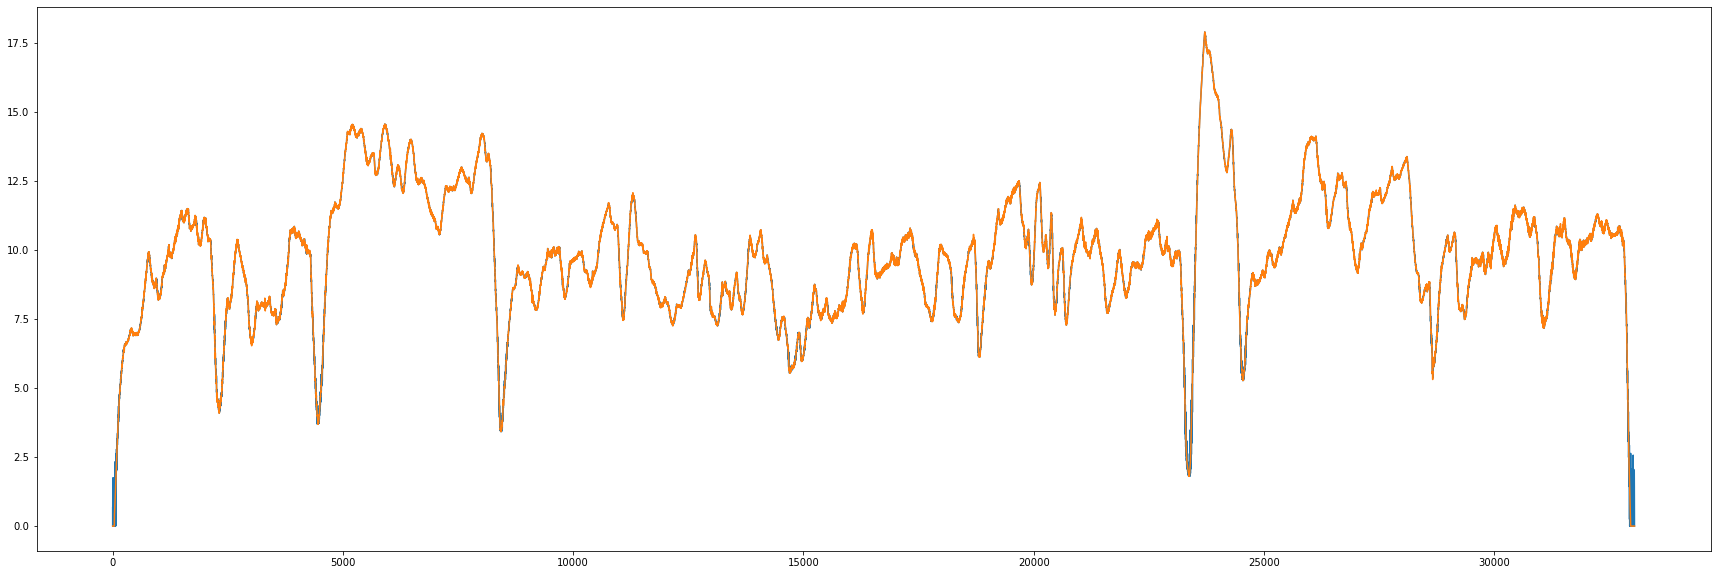

In [18]:
test_df = NvidiaDataset([root_path / "2021-10-26-10-49-06_e2e_rec_ss20_elva"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.1, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: velocity_model.find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])

/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 33281
Error mean: 0.03834242145365346, max: 2.2769237926863317


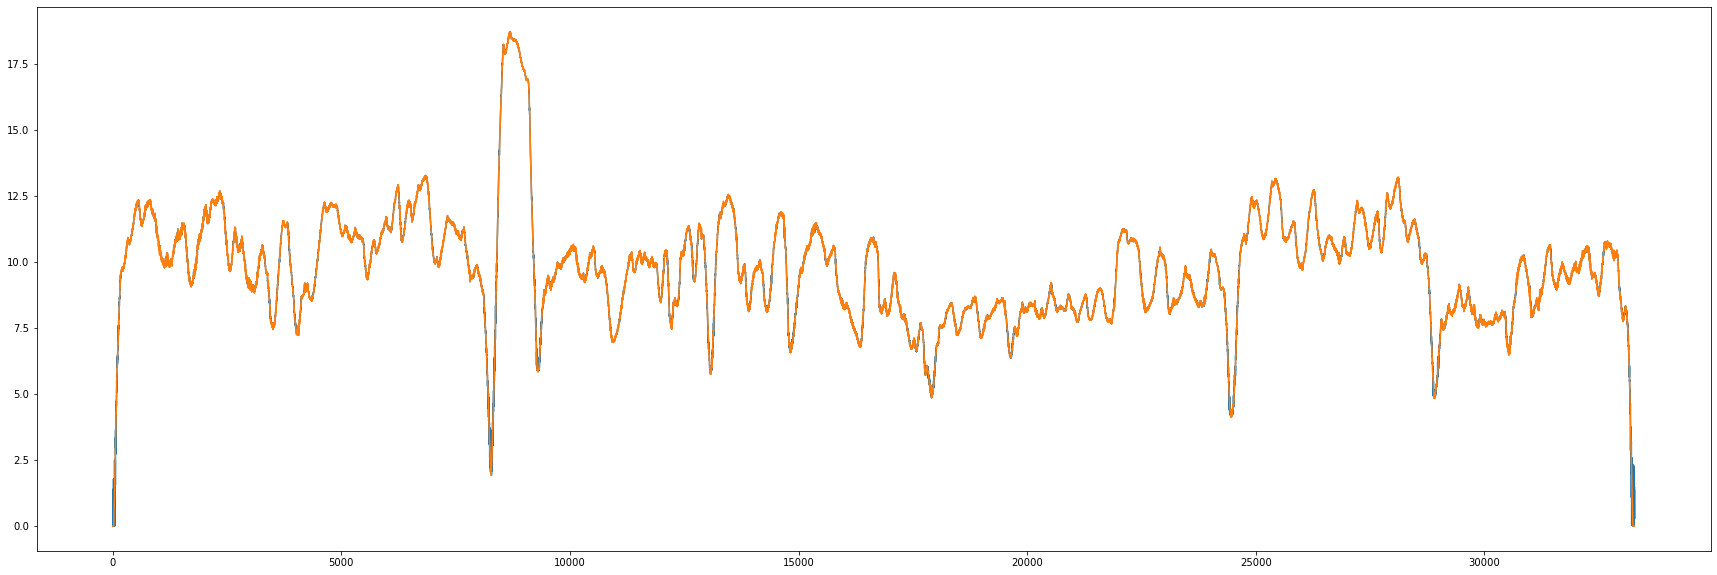

In [19]:
test_df = NvidiaDataset([root_path / "2021-10-26-11-08-59_e2e_rec_ss20_elva_back"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.1, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: velocity_model.find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])